# Coursera - Elastic Wave Equation 1D - Homogeneous Case

## Import libraries

In [9]:
import sys
!{sys.executable} -m pip install ricker

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ricker import ricker

## Define parameters

In [11]:
x_max = 10000                           # Length of the domain, m
n_ele = 125                             # Number of elements considered
len_ele = x_max/float(n_ele)            # Length of an element

c = 2500                                # Wave velocity in medium, m/s
rho = 2000                              # Constant density, kg/m3
mu = rho * c**2                         # Constant shear modulus

T_0 = 0.1                               # Ricker source dominant period
f_snap = 5                              # Snapshot frequency

N = 5                                   # Lagrange Polynomial order
xi = [-1.0, -0.7650553239294647, -0.285231516480645, 0.285231516480645, 0.7650553239294647, 1.0] # Weights for lagrange polynomial
w = [0.0666666666666667, 0.378474956297847, 0.5548583770354862, 0.5548583770354862, 0.378474956297847, 0.0666666666666667] # Weights for numerical integration

# Taking 1st derivative for Lagrange polynomial of order 5
l1d = np.array([[-7.5, -1.78636495, 0.48495105, -0.26970061, 0.23778118, -0.5],
       [10.14141594, 0.0, -1.72125695, 0.78635667, -0.65354751, 1.34991331],
       [-4.03618727, 2.52342678, 0.0, -1.75296197, 1.15282816, -2.24468465],
       [2.24468465, -1.15282816, 1.75296197, 0.0, -2.52342678, 4.03618727],
       [-1.34991331, 0.65354751, -0.78635667, 1.72125695, 0.0, -10.14141594],
       [0.5, -0.23778118, 0.26970061, -0.48495105, 1.78636495, 7.5]])
# Note: Use np.array() to correct error - tuple

M_ele = np.zeros(N+1)                   # Elemental mass matrix
K_ele = np.zeros((N+1, N+1))            # Elemental stiffness matrix

J = len_ele/float(2)                    # Jacobain matrix
J_inv = 1/float(J)                      # Inverse of Jacobian

t_n_points = 600                        # Number of time steps
k = 0
xg = np.zeros((N*n_ele)+1)
xg[k] = 0
for i in range(1, n_ele+1):
    for j in range(0, N):
        k = k+1
        xg[k] = (i-1)*len_ele + 0.5*(xi[j+1]+1)*len_ele

dxmin = min(np.diff(xg))
eps = 0.2                               # CFL stability criteria
dt = eps*dxmin/c


## Mass matrix - M

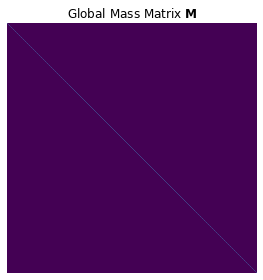

In [12]:
for i in range(0, N+1):
    M_ele[i] = rho * w[i] * J           # Elemental mass matrix

n_ele_gl = (n_ele-1)*N + N + 1          # Number of elements for a global assembly matrix
M_gl = np.zeros(2*n_ele_gl)

k = -1
for i in range(1, n_ele+1):
    for j in range(0, N+1):
        k = k + 1
        if i>1:
            if j == 0:
                k = k - 1
        M_gl[k] = M_gl[k] + M_ele[j]     # Global mass matrix

M_gl_inv = np.identity(n_ele_gl)
for i in range(0, n_ele_gl):
    M_gl_inv[i,i] = 1/float(M_gl[i])     # Inverse of global mass matrix

plt.imshow(M_gl_inv)
plt.title('Global Mass Matrix $\mathbf{M}$')
plt.axis("off")
plt.tight_layout()
plt.show()


## Stiffness matrix - K

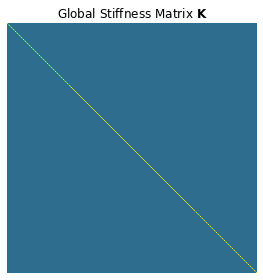

In [13]:
for i in range(0, N+1):
    for j in range(0, N+1):
        for k in range(0, N+1):
            K_ele[i,j] = K_ele[i,j] + mu*w[k]*J_inv*l1d[i,k]*l1d[j,k]  # Elemental stiffness matrix

K_gl = np.zeros([n_ele_gl, n_ele_gl])

for i in range(1, n_ele+1):
    i_0 = (i-1)*N + 1
    j_0 = i_0
    for j in range(-1, N):
        for k in range(-1, N):
            K_gl[i_0 + j, j_0 + k] = K_ele[j+1, k+1]    # Global stiffness matrix

for i in range(2, n_ele + 1):
    i_0 = (i-1)*N
    j_0 = i_0
    K_gl[i_0, j_0] = K_ele[0,0] + K_ele[N,N]


plt.imshow(K_gl)
plt.title('Global Stiffness Matrix $\mathbf{K}$')
plt.axis("off")
plt.tight_layout()
plt.show()


## Solve the global equation

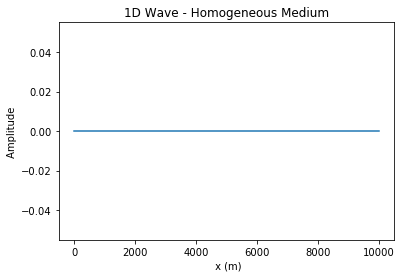

In [ ]:
source_f = ricker(dt, T_0)                              # Adding a source function
source_x = int(n_ele_gl/2)                              # Adding a source location

u = np.zeros(n_ele_gl)                                  # solution u at time n
u_next = np.zeros(n_ele_gl)                             # solution u at time n+1
u_old = np.zeros(n_ele_gl)                              # solution u at time n-1

plt.figure()
lines = plt.plot(xg, u, lw=1.5)
plt.title('1D Wave - Homogeneous Medium', size=12)
plt.xlabel(' x (m)')
plt.ylabel(' Amplitude ')
plt.rc('xtick')
plt.rc('ytick')
plt.ion()
plt.show()

for it in range(t_n_points):
    f = np.zeros(n_ele_gl)                              # force vector f at time n
    if it < len(source_f):
        f[source_x - 1] = source_f[it - 1]

    u_next = np.dot(dt**2 * M_gl_inv, (f - (np.dot(K_gl,u)))) + 2 * u - u_old   # Solving the equation
    u_old,u = u,u_next                                  # Assigning solution to the next time step

    if not it % f_snap:
        for l in lines:
            l.remove()
            del l

        lines = plt.plot(xg, u, lw=1.5)
        plt.gcf().canvas.draw()
